In [87]:
%matplotlib widget
import sys, importlib, os
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_

# matplotlib.pyplot will be used in these examples to generate the plots visualizing the data
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.widgets import Slider
import numpy as np
from scipy import signal

# import datashader as ds
# import datashader.transfer_functions as tf
import pandas as pd
import numpy as np
import pynapple as nap


import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
def detect_low_events(signal, window_size=5000, threshold_std=5, min_separation=2000,dt=0.0004):
    """
    Detects events in the signal that are below the mean - (threshold_std * std_dev),
    extracts windows around the peaks using the Hilbert transform, ensuring minimum separation between events.

    Parameters:
    signal (np.array): 1D array of signal data.
    window_size (int): Number of samples to include in each window.
    threshold_std (float): Threshold in terms of standard deviations.
    min_separation (int): Minimum number of points between consecutive events.
    
    Returns:
    list of np.array: Extracted event windows.
    """
    mean_val = np.mean(signal)
    std_val = np.std(signal)
    threshold = mean_val - (threshold_std * std_val)
    
    # Find indices where signal is below the threshold
    event_indices = np.where(signal < threshold)[0]
    
    # Ensure events are at least min_separation apart
    filtered_indices = []
    last_idx = -min_separation
    for idx in event_indices:
        if idx - last_idx >= min_separation:
            filtered_indices.append(idx)
            last_idx = idx
    
    # Compute Hilbert transform and envelope
    analytic_signal = scipy.signal.hilbert(signal)
    envelope = np.abs(analytic_signal)
    
    # Extract windows around the peak of the envelope
    windows = []
    intervals= []
    for idx in filtered_indices:
        peak_idx = idx + np.argmax(envelope[idx:idx + window_size])
        start = max(0, peak_idx - window_size // 2)
        end = min(len(signal), peak_idx + window_size // 2)
        windows.append(signal[start:end])
        intervals.append([float(start)*dt,float(end)*dt])
    
    return windows,intervals


In [88]:
event_windows,intervals = detect_low_events(data_band.d,dt=(1/fs_new))


108816
152107
168847
188250
207198
248499


In [2]:

# Go slice by slice, downsample, filter

In [56]:
data_folder = r'/Volumes/Seagate Basic/R1648-export/29-10-24/slice4/' # adjust this!
names = ['2024-10-29T13-31-56McsRecording.h5',#2024-10-29T13-31-56McsRecording
            # '2024-10-28T14-34-30slice1.h5',
            # '2024-10-28T14-51-11slice1.h5'
]
file_name = names[0]

channel_raw_data = McsPy.McsData.RawData(os.path.join(data_folder, 
                                                      file_name))

In [57]:
# get channel IDs
channel_ids =list(channel_raw_data.recordings[0].analog_streams[0].channel_infos)
#.segment_streams[0]#.segment_entity[unit].info.label
channel_ids = np.hstack(channel_ids)

Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (252, 2947000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (252,), type "|V108">


In [53]:
channel_labels = [channel_raw_data.recordings[0].analog_streams[0].channel_infos[i].info['Label'] for i in channel_ids]


In [118]:
channel_raw_data..recordings[0].#.channel_infos[10].info

datetime.datetime(2024, 10, 29, 13, 31, 56, 621192)

In [18]:
channel_raw_data.recordings[0]#.segment_streams#[0]#.segment_entity[0].info.label

<Recording label=, AnalogStreams=1, duration_time=294700000 microsecond>

In [60]:
analog_stream_0 = channel_raw_data.recordings[0].analog_streams[0]

In [61]:
# all should be the same
adc_step = analog_stream_0.channel_infos[2].adc_step.magnitude 
#get offsets
offsets = [analog_stream_0.channel_infos[id_].get_field('ADZero') for id_ in channel_ids]

In [62]:
analog_stream_0_data = analog_stream_0.channel_data

In [63]:
# Get X and Y
fs = 10000 # 10KHz

In [64]:
na = np.array
y = na(analog_stream_0_data)
# correct to Volts
y = np.subtract(y,na(offsets).reshape(-1,1))*adc_step

In [65]:
x =np.arange(0,len(y[0,:]))/fs

In [90]:
# import pynapple as nap
# preselect elecrodes where interesting things happen
# Filter LFPs
# fs = 
extra_threhsold =[]
downsample_factor = 4
fs_new = fs // downsample_factor  # New sampling rate (2500 Hz)
data_to_store = []
for i in range(252):
    y_down = signal.decimate(y[i,:], downsample_factor, ftype="fir")
    tsd = nap.Tsd(t=x[::downsample_factor], d=y_down,columns = np.arange(0,y.shape[0]))
    # get only LFP ignore all spikes 
    data_band = nap.apply_bandpass_filter(tsd, cutoff=(.1, 200.0), fs=fs_new,mode='butter', order=6)
    extr_thr = np.sum(data_band < (np.mean(data_band)-np.std(data_band))*7)
    if extr_thr>0:
        event_windows,intervals = detect_low_events(data_band.d,dt=(1/fs_new))
        data_to_store.append([file_name,data_folder,channel_labels[i],event_windows,intervals])
    # else:
        
    # extra_threhsold.append()
    

108816
152107
168847
188250
207198
248499
108835
152107
168854
188206
248591
6902
21812
29859
31420
37066
37066
40856
43559
47353
48816
108848
152175
169038
188259
248586
108798
152101
169124
181197
188538
206813
248570
108827
152142
169586
188086
248586
108860
152121
169495
188558
248584
108786
152130
168951
188070
206816
248565
108926
169168
108805
152117
168946
181153
188441
206943
248569
108823
152162
168957
181387
188478
248557
108801
152110
168852
181772
188472
206990
248564
108795
152038
168842
181131
188447
206814
248438
108823
152116
168944
181770
188452
206819
248535
108806
152107
169078
181157
188461
206808
248448
108837
152131
169101
188434
734249
108844
152068
168949
181145
188465
206927
248469
108816
152073
168970
181131
188432
206816
248550
108813
152115
168845
181374
188436
206947
248532
108814
152081
168948
181133
188455
206816
248564
108825
152099
168957
181773
188312
206922
248545
108818
152127
168932
181850
188452
248593
108839
152074
168970
181371
188441
206934
248

/Users/ovinogradov/miniconda3/envs/sliceMEA/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


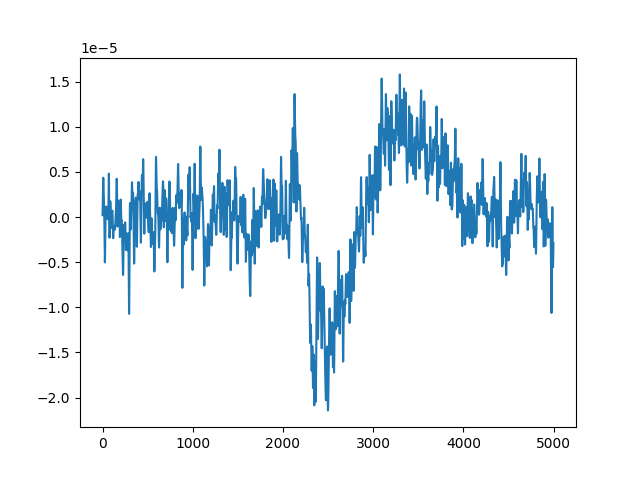

In [99]:
plt.figure()
plt.plot(pd.DataFrame(data_to_store)[3][0][3])

/Users/ovinogradov/miniconda3/envs/sliceMEA/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


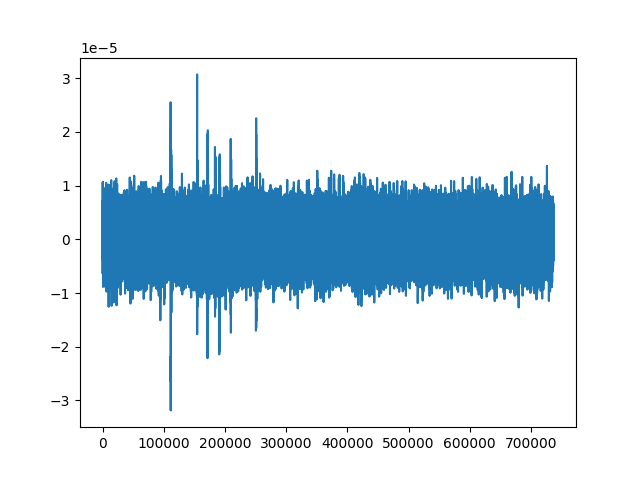

In [81]:
plt.figure()
plt.plot(data_band.d)

In [105]:
i

55

In [91]:
# tsd = nap.Tsd(t=x[::downsample_factor], d=y_down,columns = np.arange(0,y.shape[0]))

In [115]:
super_thr = data_band.d < (np.mean(data_band.d)-np.std(data_band.d))*5



/Users/ovinogradov/miniconda3/envs/sliceMEA/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


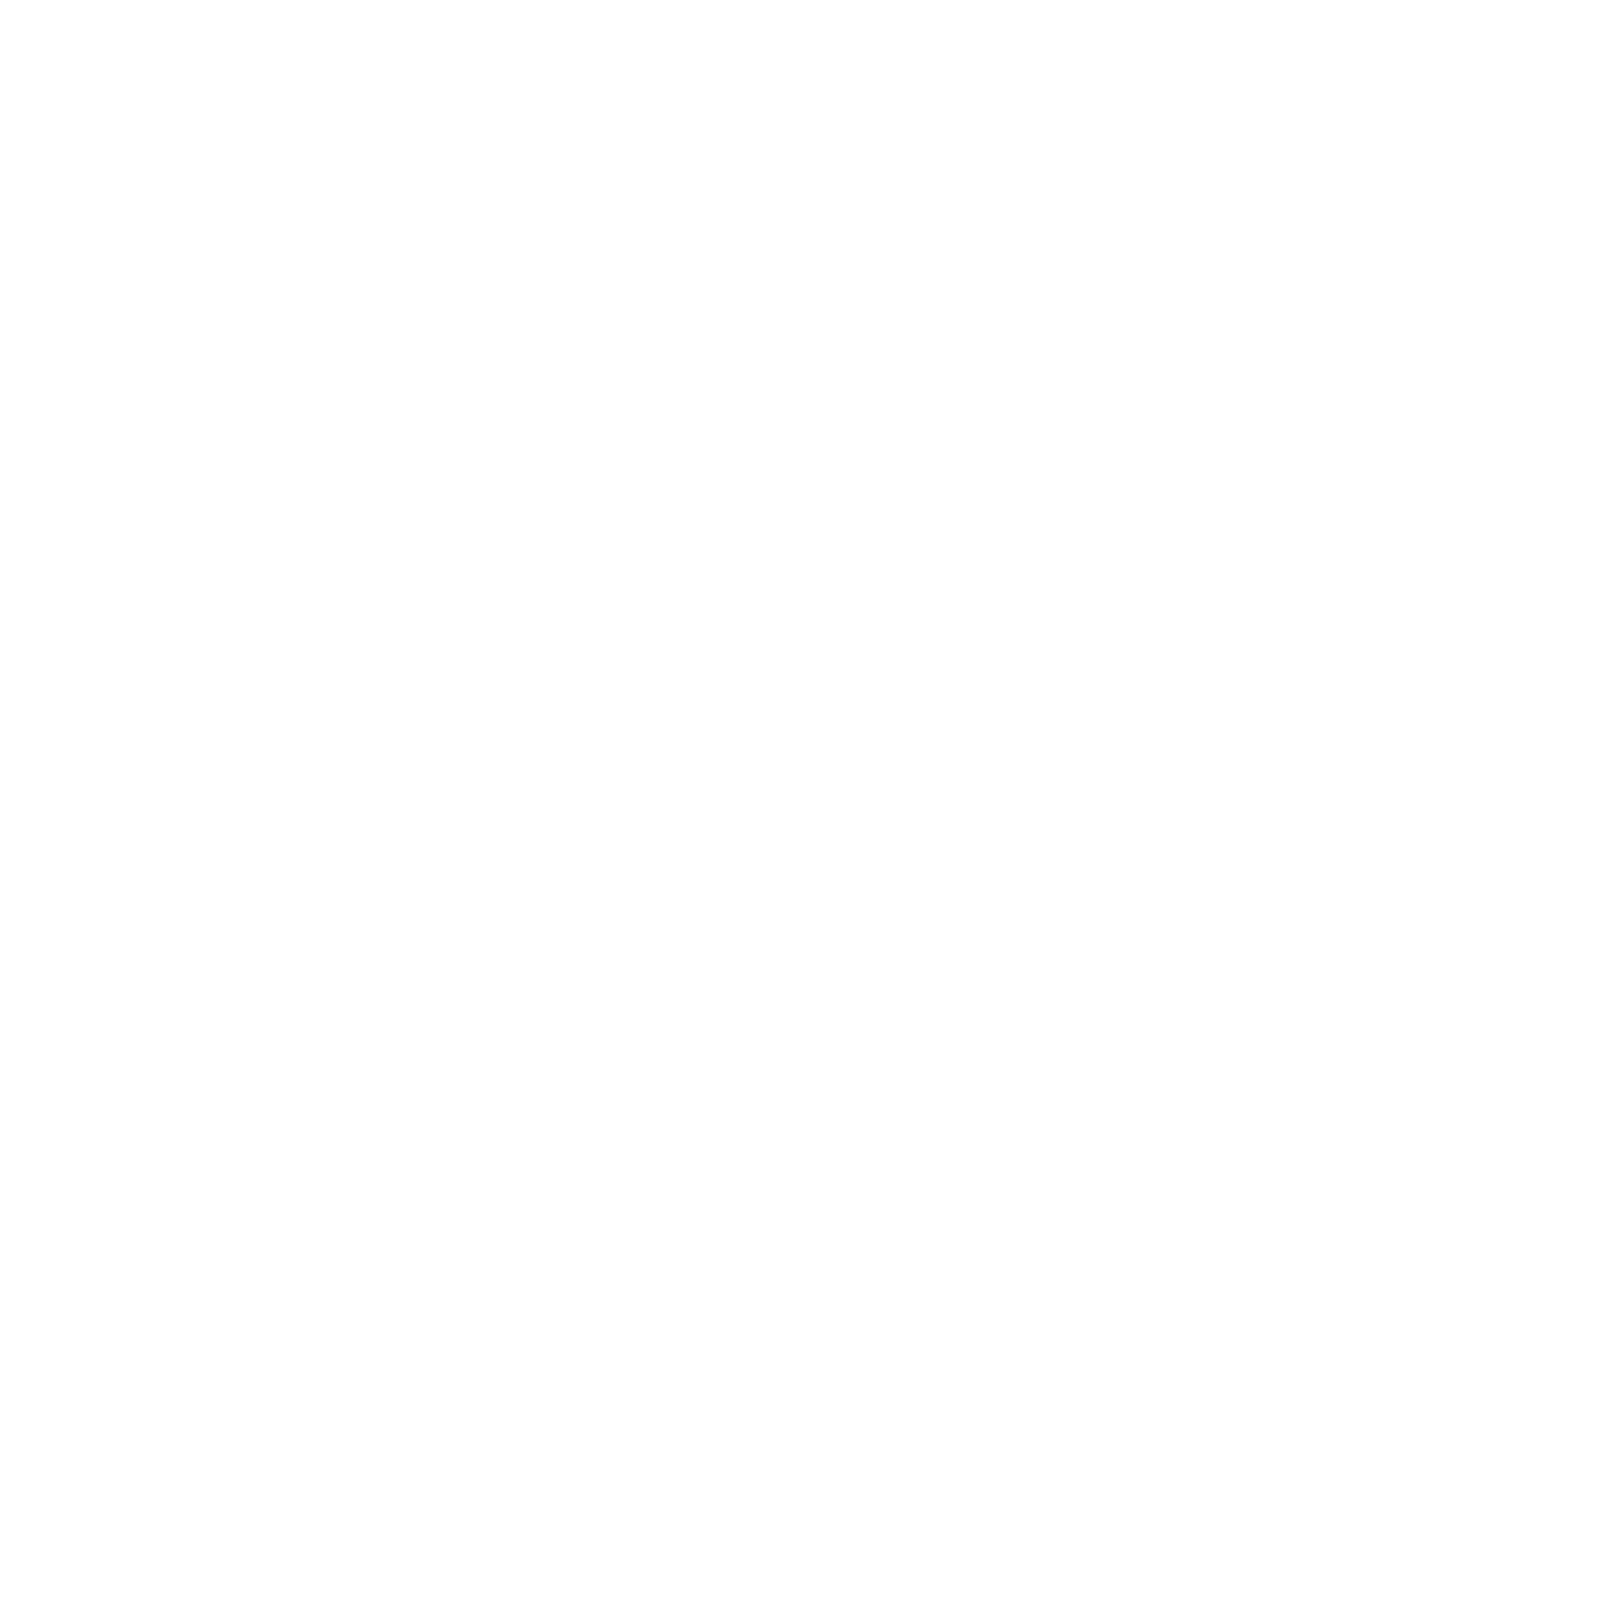

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create a figure
def get_axes():
    fig, axs = plt.subplots(16, 16, figsize=(8, 8),dpi=200)
    letters = ['A','B','C','D','E','F','G','H','J','K','L','M','N','O','P','R']
    # Set the labels for each subplot
    labels = [
        [f"{letters[j]}{i + 1}" for j in range(16)] for i in range(16)
    ]

    # Plot circles with text in each subplot
    ax_dict = {}
    for i in range(16):
        for j in range(16):
            ax = axs[i, j]
            ax.axis('off')
#             circle = patches.Circle((0.5, 0.5), radius=0.4,facecolor=[1,1,1],edgecolor='skyblue')#, color='skyblue')
#             ax.add_patch(circle)
            ax_dict[labels[i][j]] =ax
    return fig, ax_dict

fig,ax = get_axes()    

In [144]:
1/fs_new

0.0004

In [149]:



event_windows,intervals = detect_low_events(data_band.d,dt=(1/fs_new))

# Plotting the signal and threshold
plt.figure(figsize=(10, 4))
plt.plot(data_band.d, label="Signal")
plt.axhline(np.mean(data_band.d) - (5 * np.std(data_band.d)), color='r', linestyle='--', label="Threshold")
plt.legend()
plt.title("Detected Low Events")
plt.show()

print(f"Detected {len(event_windows)} events.")

IndexError: invalid index to scalar variable.

In [152]:
epochs = nap.IntervalSet(na(intervals)) 

/Users/ovinogradov/miniconda3/envs/sliceMEA/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


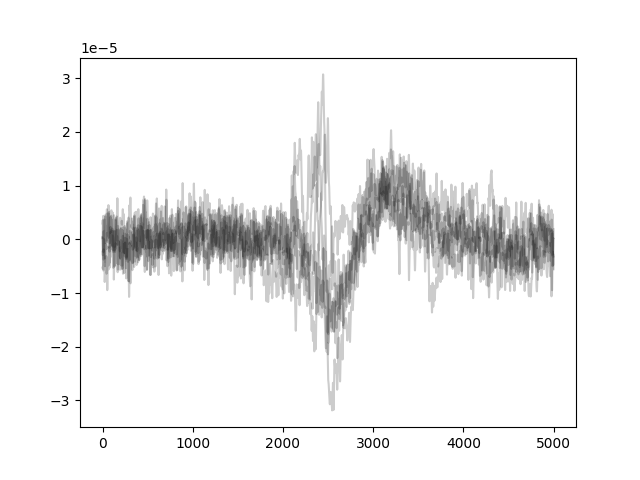

In [179]:
plt.figure()

[plt.plot(event_windows[i],'k',alpha=0.2) for i in range(6)];

In [119]:
# dt = 1/fs_new
# np.diff(np.where(super_thr)[0]*dt)

/Users/ovinogradov/miniconda3/envs/sliceMEA/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


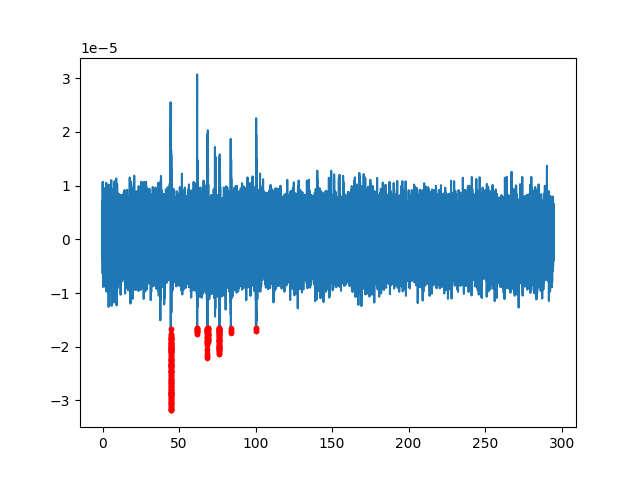

In [118]:

plt.figure()
plt.plot(data_band)
plt.plot(data_band.t[super_thr],data_band.d[super_thr],'.r')

/Users/ovinogradov/miniconda3/envs/sliceMEA/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


Text(0.5, 0, 'Time (s)')

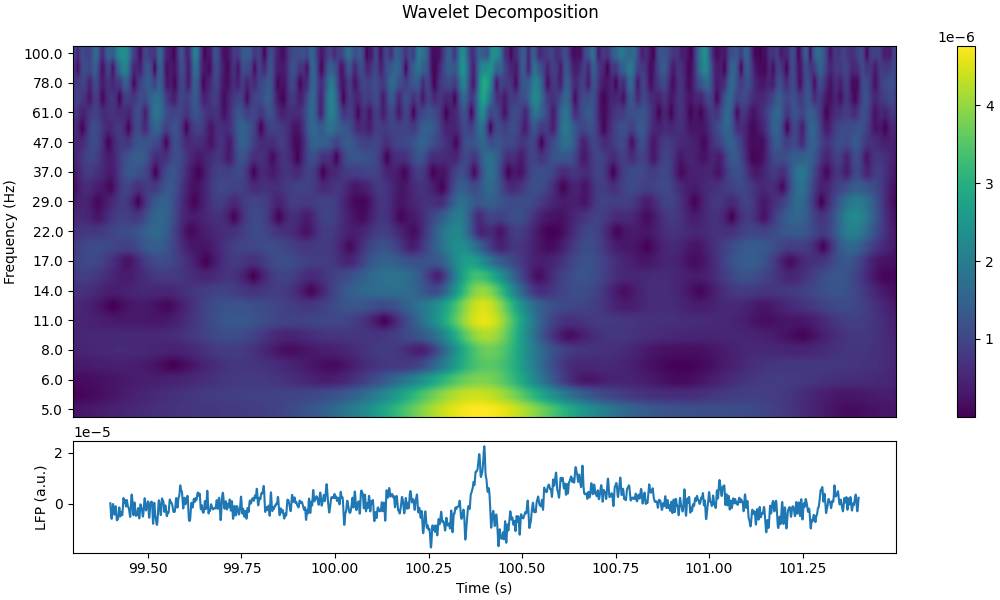

In [175]:
# Define wavelet decomposition plotting function
def plot_timefrequency(freqs, powers, ax=None):
    im = ax.imshow(np.abs(powers), aspect="auto")
    ax.invert_yaxis()
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)")
    ax.get_xaxis().set_visible(False)
    ax.set(yticks=np.arange(len(freqs))[::2], yticklabels=np.rint(freqs[::2]))
    ax.grid(False)
    return im

ep = 5
freqs = np.geomspace(5, 100, 25)
cwt_rem = nap.compute_wavelet_transform(data_band.restrict(epochs[ep]), fs=fs_new, freqs=freqs)

fig = plt.figure(constrained_layout=True, figsize=(10, 6))
fig.suptitle("Wavelet Decomposition")
gs = plt.GridSpec(2, 1, figure=fig, height_ratios=[1.0, 0.3])

ax0 = plt.subplot(gs[0, 0])
im = plot_timefrequency(freqs, np.transpose(cwt_rem[:, :].values), ax=ax0)
cbar = fig.colorbar(im, ax=ax0, orientation="vertical")

ax1 = plt.subplot(gs[1, 0])
ax1.plot(data_band.restrict(epochs[ep]))
ax1.set_ylabel("LFP (a.u.)")
ax1.set_xlabel("Time (s)")
# ax1.margins(0)

/Users/ovinogradov/miniconda3/envs/sliceMEA/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


[]

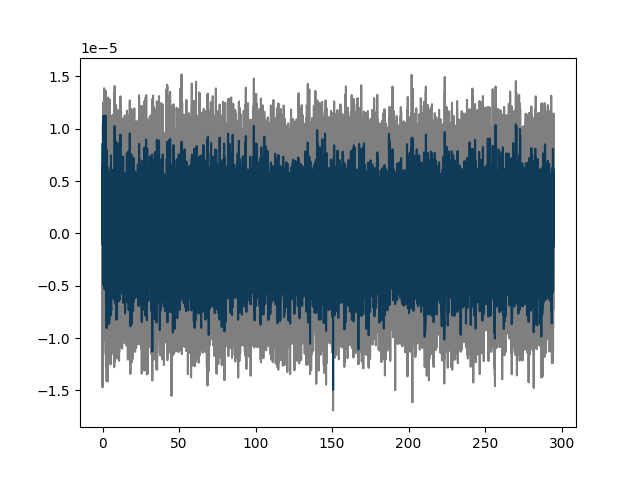

In [84]:
plt.figure()
plt.plot(data_band)
# plt.plot(x,y[i,:],alpha=0.5)
tsd_ = nap.TsdFrame(t=x, d=y[i,:],columns = np.arange(0,y.shape[0]))
data_band_ = nap.apply_bandpass_filter(tsd_, cutoff=(.1, 100.0), fs=fs_new,mode='butter', order=6)
plt.plot(data_band_,'k',alpha=0.5)

plt.plot()

In [12]:
detected_electrodes = np.where(na(ss)>0)[0]

/Users/ovinogradov/miniconda3/envs/sliceMEA/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


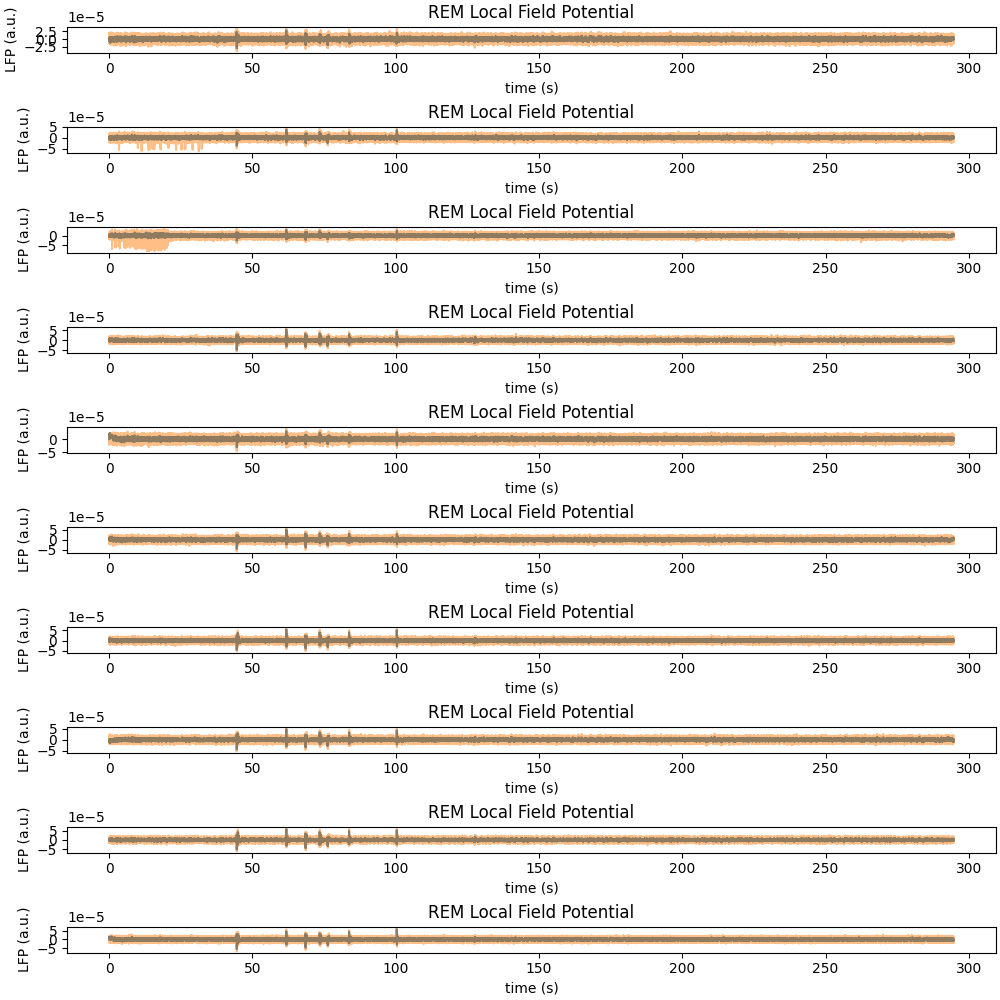

In [15]:
# plt.figure()
electrode = 119

fig, ax = plt.subplots(10, constrained_layout=True, figsize=(10, 10))


for i_n,i in enumerate(detected_electrodes[:10]):
    tsd = nap.TsdFrame(t=x, d=y[i,:],columns = np.arange(0,y.shape[0]))
    data_band = nap.apply_bandpass_filter(tsd, cutoff=(.1, 100.0), fs=fs,mode='butter', order=6)
    
    ax[i_n].plot(data_band)
    ax[i_n].plot(tsd,alpha=0.5)
    # ax.plot(t_down,y_down)
    # ax.plot(data)
ax[0].set_title("REM Local Field Potential")
ax[0].set_ylabel("LFP (a.u.)")
ax[0].set_xlabel("time (s)")

/Users/ovinogradov/miniconda3/envs/sliceMEA/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


Text(0.5, 0, 'time (s)')

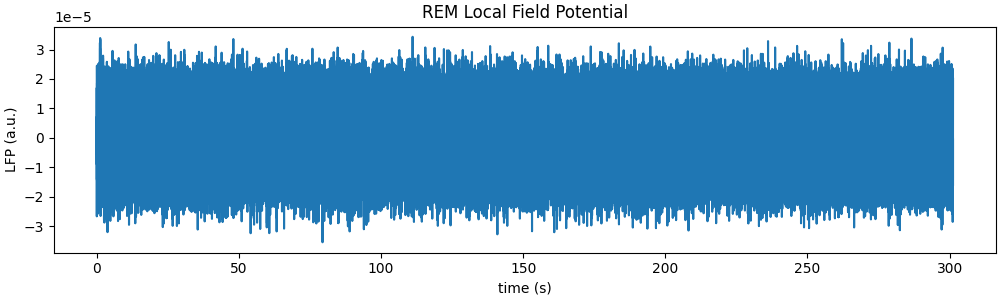

In [23]:
tsd = nap.TsdFrame(t=t_down, d=y_down,columns = np.arange(0,y.shape[0]))

In [50]:
import pynapple as nap
# Filter LFPs
# fs = 
fs_new = fs // downsample_factor  # New sampling rate (400 Hz)
data_band = nap.apply_bandpass_filter(tsd, cutoff=(.5, 300.0), fs=fs_new,mode='butter', order=2)
data =na(data_band)

/Users/ovinogradov/miniconda3/envs/sliceMEA/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


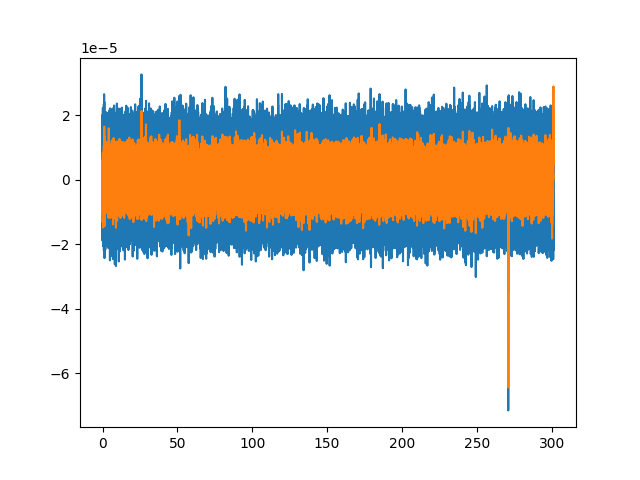

In [51]:
plt.figure()
plt.plot(x,y[electrode,:])
plt.plot(t_down,data)
# plt.xlim(25027,32.)
# plt.ylim(-.0005,0.0005)